Using this tutorial: https://www.datascience.com/resources/notebooks/random-forest-intro

In [154]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import os
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing
import course_utils as bd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

In [2]:
# Import data (for Mac the "\\" might be replaced by "/")
cwd = os.getcwd()
data = pd.read_csv(cwd + "\\WA_Fn-UseC_-Sales-Win-Loss.csv", index_col = 0)

In [3]:
# Format variable names
names = list(data.columns)

for i in range(len(names)):
    names[i] = names[i].replace(" ", "")
    
# Rename selected variables
indeces = [
    4, 7, 8, 9,
    10, 11, 12, 
    14, 15, 16
    ]

names_update = [
    "DaysSales", "DaysClosing", "DaysQualified", "OpportunityAmount",
    "ClientRevenue", "ClientEmployees", "PastRevenue",
    "IdentifiedDaysRatio", "ValidatedDaysRatio", "QualifiedDaysRatio"
    ]

for ind, i in zip(indeces, range(len(indeces))):
    names[ind] = names_update[i]
    
data.columns = names

In [4]:
data.head()

,SuppliesSubgroup,SuppliesGroup,Region,RouteToMarket,DaysSales,OpportunityResult,SalesStageChangeCount,DaysClosing,DaysQualified,OpportunityAmount,ClientRevenue,ClientEmployees,PastRevenue,CompetitorType,IdentifiedDaysRatio,ValidatedDaysRatio,QualifiedDaysRatio,DealSizeCategory
Opportunity Number,,,,,,,,,,,,,,,,,,
1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.69636,0.113985,0.154215,1
1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.00000,1.000000,0.000000,1
1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.00000,0.000000,0.000000,1
1675224,Shelters & RV,Performance & Non-auto,Midwest,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.00000,0.000000,0.000000,1
1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.00000,0.141125,0.000000,4


In [5]:
# Remove data with opportunity amount = 0
data = data[data.OpportunityAmount != 0]

In [6]:
data.columns

Index(['SuppliesSubgroup', 'SuppliesGroup', 'Region', 'RouteToMarket',
       'DaysSales', 'OpportunityResult', 'SalesStageChangeCount',
       'DaysClosing', 'DaysQualified', 'OpportunityAmount', 'ClientRevenue',
       'ClientEmployees', 'PastRevenue', 'CompetitorType',
       'IdentifiedDaysRatio', 'ValidatedDaysRatio', 'QualifiedDaysRatio',
       'DealSizeCategory'],
      dtype='object')

In [7]:
# Data Preparation

# First change opportunity result(our target variable) to numeric
data_clean = data.copy()
minority = data_clean['OpportunityResult'].value_counts().idxmin()
result = np.array((data_clean['OpportunityResult'] == minority).astype(int))
data_clean = data_clean.drop(['OpportunityResult'], axis = 1)

# Drop variables relating to days
data_clean = data_clean.drop(["DaysSales", "SalesStageChangeCount", "DaysClosing", "DaysQualified", 'IdentifiedDaysRatio', 
                              'ValidatedDaysRatio', 'QualifiedDaysRatio', "DealSizeCategory"], axis = 1)

# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
# (This may not be a good step because it adds too many columns, but we'll see)
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop([col], axis = 1)
# Check if there is any null value in our dataset
if data_clean.isnull().any().any():
    print('NO!!!!!')
# Gladly, we don't have any

data_clean['result'] = result

# Random forest doesn't require normalization!

In [8]:
data_clean.head()

,OpportunityAmount,ClientRevenue,ClientEmployees,PastRevenue,SuppliesSubgroup Replacement Parts indicator,SuppliesSubgroup Tires & Wheels indicator,SuppliesSubgroup Batteries & Accessories indicator,SuppliesSubgroup Car Electronics indicator,SuppliesSubgroup Exterior Accessories indicator,SuppliesSubgroup Towing & Hitches indicator,SuppliesSubgroup Performance Parts indicator,SuppliesSubgroup Shelters & RV indicator,SuppliesSubgroup Interior Accessories indicator,SuppliesSubgroup Garage & Car Care indicator,SuppliesSubgroup Motorcycle Parts indicator,SuppliesGroup Performance & Non-auto indicator,SuppliesGroup Car Electronics indicator,SuppliesGroup Tires & Wheels indicator,SuppliesGroup Car Accessories indicator,Region Southwest indicator,Region Northwest indicator,Region Pacific indicator,Region Midwest indicator,Region Mid-Atlantic indicator,Region Southeast indicator,Region Northeast indicator,RouteToMarket Reseller indicator,RouteToMarket Other indicator,RouteToMarket Fields Sales indicator,RouteToMarket Telesales indicator,RouteToMarket Telecoverage indicator,CompetitorType Unknown indicator,CompetitorType None indicator,CompetitorType Known indicator,result
Opportunity Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1674737,7750,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
1689785,69756,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1692390,232522,5,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1935837,20001,4,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1952571,450000,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [9]:
print("Here's the data types of our columns:\n",
     data_clean.dtypes)

Here's the data types of our columns:
 OpportunityAmount                                     int64
ClientRevenue                                         int64
ClientEmployees                                       int64
PastRevenue                                           int64
SuppliesSubgroup Replacement Parts indicator          int32
SuppliesSubgroup Tires & Wheels indicator             int32
SuppliesSubgroup Batteries & Accessories indicator    int32
SuppliesSubgroup Car Electronics indicator            int32
SuppliesSubgroup Exterior Accessories indicator       int32
SuppliesSubgroup Towing & Hitches indicator           int32
SuppliesSubgroup Performance Parts indicator          int32
SuppliesSubgroup Shelters & RV indicator              int32
SuppliesSubgroup Interior Accessories indicator       int32
SuppliesSubgroup Garage & Car Care indicator          int32
SuppliesSubgroup Motorcycle Parts indicator           int32
SuppliesGroup Performance & Non-auto indicator        int32
S

In [10]:
# Check for class imbalance
data_clean[data_clean.result == 1]["result"].sum() / len(data_clean)

0.22761852115085945

In [11]:
# Create training and test data
feature_space = data_clean.iloc[:, data_clean.columns != 'result']
feature_class = data_clean.iloc[:, data_clean.columns == 'result']

training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20,
                                                                    random_state = 42)

# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel()
test_class_set = test_class_set.values.ravel()

Now, let's create the model, starting with parameter tuning. Here are the parameters we will be tuning in this tutorial: 

- **max_depth**: The maximum splits for all trees in the forest.
- **bootstrap**: An indicator of whether or not we want to use bootstrap samples when building trees.
- **max_features**: The maximum number of features that will be used in node splitting — the main difference I previously mentioned between bagging trees and random forest. Typically, you want a value that is less than p, where p is all features in your data set.
- **criterion**: This is the metric used to asses the stopping criteria for the decision trees.

Utilizing the GridSearchCV functionality, let's create a dictionary with parameters we are looking to optimize to create the best model for our data. Setting the n_jobs to 3 tells the grid search to run three jobs in parallel, reducing the time the function will take to compute the best parameters.

In [12]:
# Set the random state for reproductibility
fit_rf = RandomForestClassifier(random_state=42)

In [13]:
# start = time.time()
# param_dist = {'max_depth': [2, 3, 4],
#               'bootstrap': [True, False],
#               'max_features': ['auto', 'sqrt', 'log2', None],
#               'criterion': ['gini', 'entropy']}

# cv_rf = GridSearchCV(fit_rf, cv = 10,
#                      param_grid=param_dist,
#                      n_jobs = 3)

# cv_rf.fit(training_set, class_set)

# print('Best Parameters using grid search: \n',
#       cv_rf.best_params_)

# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

In [14]:
# Set best parameters given by grid search, except bootstrap
fit_rf.set_params(criterion = 'gini',
                  max_features = None,
                  max_depth = 4)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [15]:
# Calculate the out-of-bag error rate
fit_rf.set_params(warm_start=True,
                  oob_score=True)

min_estimators = 15
max_estimators = 500

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set, class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

In [16]:
# Convert dictionary to a pandas series for easy plotting
oob_series = pd.Series(error_rate)

Text(0.5,1,'OOB Error Rate Across various Forest sizes \n(From 15 to 500 trees)')

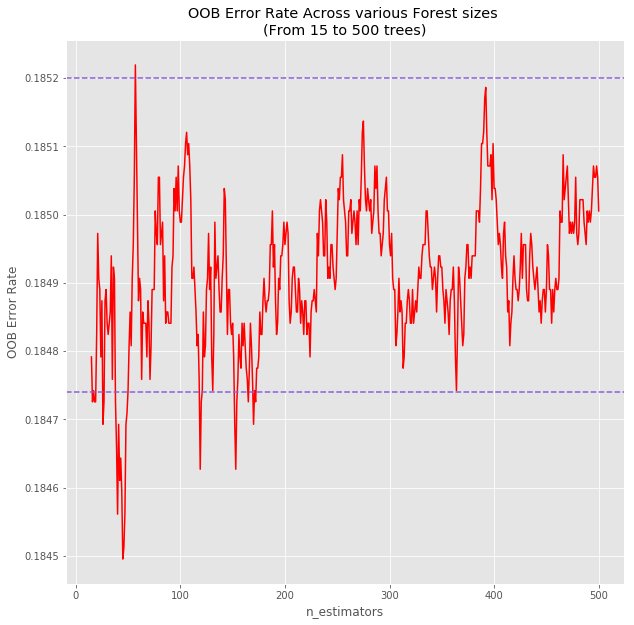

In [22]:
# Plot out-of-bag-errors
fig, ax = plt.subplots(figsize=(10, 10))

#ax.set_axis_bgcolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.18474,
            color='#875FDB',
           linestyle='--')
plt.axhline(0.1852,
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 500 trees)')

Use 200 estimator for the model

In [20]:
print('OOB Error rate for 200 trees is: {0:.5f}'.format(oob_series[200]))

OOB Error rate for 200 trees is: 0.18496


In order for this methodology to work, we must set the number of trees calculated using the OOB error rate, and remove the warm_start and oob_score parameters, as well as include the bootstrap parameter.

In [112]:
fit_rf.set_params(n_estimators=200,
              bootstrap = True,
              warm_start=False,
              oob_score=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [113]:
# Train the algorithm
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [114]:
# Get feature importance using gini impurity
importances_rf = fit_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

In [115]:
names_index = data_clean.columns[:-1]

In [116]:
def variable_importance(importance, indices):
    """
    Purpose:
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on gini or information gain for CART model.

    Parameters:
    ----------
    names:      Name of columns included in model
    importance: Array returned from feature_importances_ for CART
                   models organized by dataframe index
    indices:    Organized index of dataframe from largest to smallest
                   based on feature_importances_

    Returns:
    ----------
    Print statement outputting variable importance in descending order
    """
    print("Feature ranking:")

    for f in range(len(names_index)):
        i = f
        print("%d. The feature '%s' \
has a Mean Decrease in Gini of %f" % (f + 1,
                                         names_index[indices[i]],
                                         importance[indices[f]]))

In [117]:
variable_importance(importances_rf, indices_rf)

Feature ranking:
1. The feature 'PastRevenue' has a Mean Decrease in Gini of 0.622399
2. The feature 'OpportunityAmount' has a Mean Decrease in Gini of 0.318374
3. The feature 'RouteToMarket Reseller indicator' has a Mean Decrease in Gini of 0.038943
4. The feature 'CompetitorType None indicator' has a Mean Decrease in Gini of 0.007240
5. The feature 'RouteToMarket Fields Sales indicator' has a Mean Decrease in Gini of 0.006146
6. The feature 'SuppliesSubgroup Motorcycle Parts indicator' has a Mean Decrease in Gini of 0.004223
7. The feature 'Region Midwest indicator' has a Mean Decrease in Gini of 0.002032
8. The feature 'ClientRevenue' has a Mean Decrease in Gini of 0.000249
9. The feature 'ClientEmployees' has a Mean Decrease in Gini of 0.000081
10. The feature 'CompetitorType Unknown indicator' has a Mean Decrease in Gini of 0.000064
11. The feature 'Region Northwest indicator' has a Mean Decrease in Gini of 0.000054
12. The feature 'Region Mid-Atlantic indicator' has a Mean Decrea

In [118]:
# Make predictions
predictions_rf = fit_rf.predict(test_set)

# Create confusion matrix
test_crosstb = pd.crosstab(index = test_class_set,
                           columns = predictions_rf)

test_crosstb = test_crosstb.rename(columns= {0: 'Lost', 1: 'Won'})
test_crosstb.index = ['Lost', 'Won']
test_crosstb.columns.name = 'n = 15605'

test_crosstb

n = 15605,Lost,Won
Lost,11426,346
Won,2415,1009


In [119]:
accuracy_rf = fit_rf.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.818


In [120]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.1817


In [121]:
# Calculate ROC
fpr2, tpr2, _ = roc_curve(predictions_rf,
                      test_class_set)
predictions_prob = fit_rf.predict_proba(test_set)[:, 1]

In [122]:
# Calculate AUC
auc_rf = auc(fpr2, tpr2)

In [123]:
# Plot the AUC
def plot_roc_curve(fpr, tpr, auc, mod, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    fpr:  Array returned from sklearn.metrics.roc_curve for increasing
         false positive rates
    tpr:  Array returned from sklearn.metrics.roc_curve for increasing
         true positive rates
    auc:  Float returned from sklearn.metrics.auc (Area under Curve)
    mod:  String represenation of appropriate model, can only contain the
         following: ['knn', 'rf', 'nn']
    xlim: Set upper and lower x-limits
    ylim: Set upper and lower y-limits

    Returns:
    ----------
    Returns plot of Receiving Operating Curve for specific model. Allowing user to
    specify x and y-limits.
    """
    mod_list = ['knn', 'rf', 'nn']
    method = [('Kth Nearest Neighbor', 'deeppink'),
          ('Random Forest', 'red'),
          ('Neural Network', 'purple')]

    plot_title = ''
    color_value = ''
    for i in range(0, 3):
        if mod_list[i] == mod:
            plot_title = method[i][0]
            color_value = method[i][1]

    fig, ax = plt.subplots(figsize=(10, 10))
    #ax.set_axis_bgcolor('#fafafa')

    plt.plot(fpr, tpr,
         color=color_value,
         linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
#     plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
#     plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

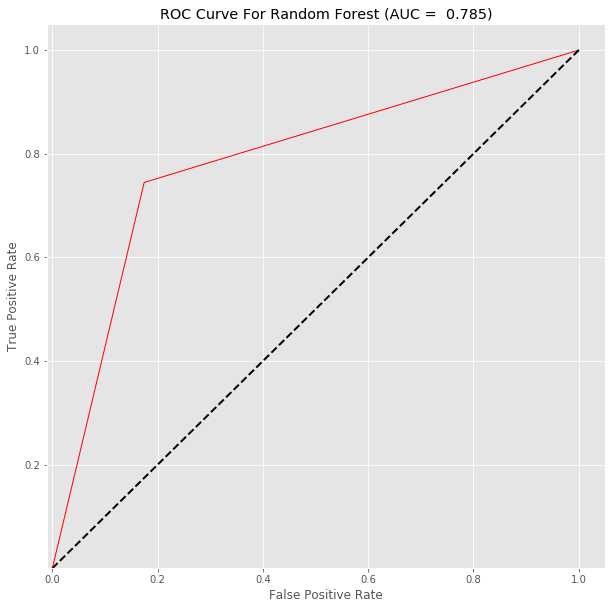

In [124]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
           xlim=(-0.01, 1.05),
           ylim=(0.001, 1.05))

These are AUC values for different tree n_estimators:
- 30: AUC = 0.785
- 100: AUC = 0.786
- 200: AUC = 0.785
- 300: AUC = 0.786
- 500: AUC = 0.785

## Model selection
Using the code from the lecture

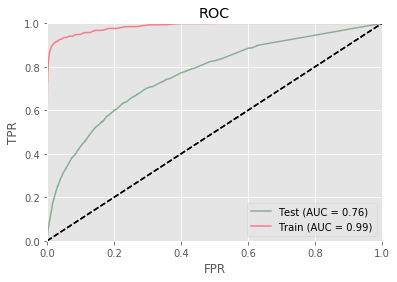

In [196]:
# First train a model and assess its performance on both the training, the validating and the test data
rf_def = RandomForestClassifier(n_estimators=30, bootstrap = True, warm_start=False,oob_score=True)
rf_def = rf_def.fit(training_set, class_set)
rf_pred_test = rf_def.predict_proba(test_set)
rf_pred_train = rf_def.predict_proba(training_set)

bd.plotAUC(test_class_set, rf_pred_test[:,1], 'Test')
bd.plotAUC(class_set, rf_pred_train[:,1], 'Train')
bd.plotAUC(class_set, rf_def.oob_decision_function_[:,1], 'OOB')
plt.show()

In [183]:
# Now run the model with different parameters
n_est = [50, 100, 200, 500, 1000]
m_feat = [1, 3, 6, 11]

aucs_oob = {}
aucs_test = {}

for m in m_feat:
    aucs_oob[m] = []
    aucs_test[m] = []
    for n in n_est:
        rf_oob = RandomForestClassifier(criterion='gini', n_estimators=n, max_features=m, oob_score=True)
        rf_oob = rf_oob.fit(training_set, class_set)
        aucs_oob[m].append(roc_auc_score(class_set, rf_oob.oob_decision_function_[:,1]))
        aucs_test[m].append(roc_auc_score(test_class_set, rf_oob.predict_proba(test_set)[:,1]))

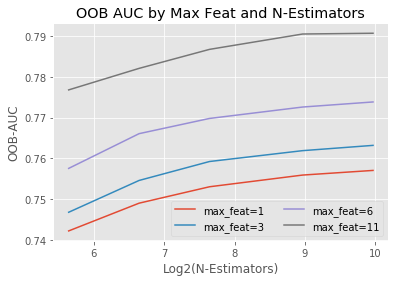

In [184]:
# Plot the scores on the OOB

x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_oob[m], label='max_feat={}'.format(m))
    
plt.title('OOB AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('OOB-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

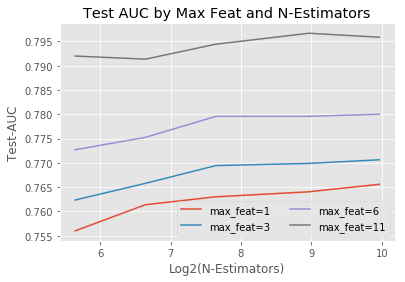

In [185]:
# Now plot the model performances on the real test data
x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_test[m], label='max_feat={}'.format(m))
    
plt.title('Test AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('Test-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

In [200]:
# Train a model on the best options found above (n_estimator = 500, max_feat = 11) and then look at the feature importances.
from sklearn.ensemble import RandomForestClassifier

rf_best = RandomForestClassifier(criterion='gini', n_estimators = 500, max_features=11, oob_score = True)
rf_best = rf_best.fit(training_set, class_set)

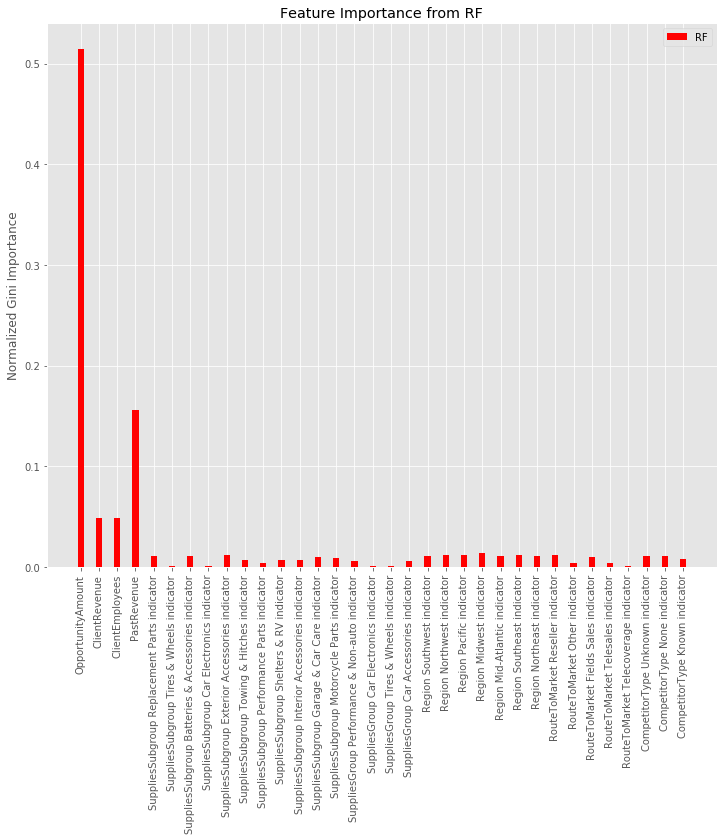

In [201]:
%matplotlib inline

cols = training_set.columns.values
rf_fi = rf_best.feature_importances_

fig, ax = plt.subplots(figsize = (12, 10))
width=0.35

ax.bar(np.arange(len(cols)), rf_fi, width, color='r', label='RF')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=90)
plt.title('Feature Importance from RF')
ax.set_ylabel('Normalized Gini Importance')
plt.legend(loc=1)



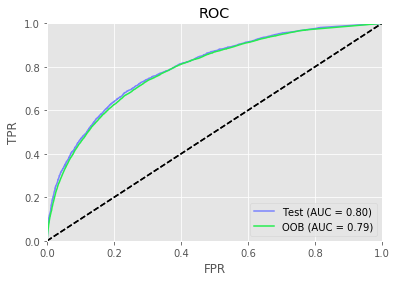

In [202]:
# Finally make predictions and plot the ROC-curve for the best model
rf_best_pred_test = rf_best.predict_proba(test_set)

bd.plotAUC(test_class_set, rf_best_pred_test[:,1], 'Test')
bd.plotAUC(class_set, rf_best.oob_decision_function_[:,1], 'OOB')
plt.show()

In [208]:
# Train one model with unlimited max_features
rf_best2 = RandomForestClassifier(criterion='gini', n_estimators = 500, max_features=None, oob_score = True)
rf_best2 = rf_best2.fit(training_set, class_set)

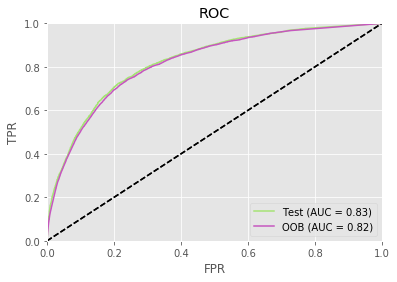

In [220]:
# Predict and plot
rf_best2_pred_test = rf_best2.predict_proba(test_set)

bd.plotAUC(test_class_set, rf_best2_pred_test[:,1], 'Test')
bd.plotAUC(class_set, rf_best2.oob_decision_function_[:,1], 'OOB')
plt.show()

In [237]:
# Try once more differenct tree sizes for max_features = None
# Now run the model with different parameters
n_est = [50, 100, 200, 500, 1000]

aucs_oob = {}
aucs_test = {}

aucs_oob = []
aucs_test = []

for n in n_est:
    rf_oob = RandomForestClassifier(criterion='gini', n_estimators=n, max_features= None, oob_score=True)
    rf_oob = rf_oob.fit(training_set, class_set)
    aucs_oob.append(roc_auc_score(class_set, rf_oob.oob_decision_function_[:,1]))
    aucs_test.append(roc_auc_score(test_class_set, rf_oob.predict_proba(test_set)[:,1]))

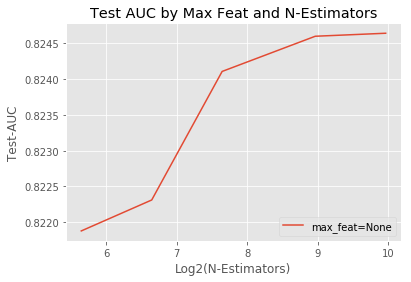

In [245]:
# Now plot the model performance on the real test data
x = np.log2(np.array(n_est))
plt.plot(x, aucs_test, label='max_feat=None'.format(m))
    
plt.title('Test AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('Test-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

In [246]:
# Turns out that n_est = 1000 is even slightly better!
aucs_test

[0.8218772650968081,
 0.8223101392382051,
 0.8241089932828095,
 0.8246013603283253,
 0.8246434370444997]

### Tomorrow write one clean script:
1) Data cleaning & split on test & training data from Xiao <br>
2) Hyperparameter Tuning: Either use combination of Gridsearch and looping through n_estim or write a new version of GridSearch (see: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) <br>